# Financial Transactions

Data Source: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets/data

This data source has five data files:
- cards_data.csv
- transactions_data.csv
- users_data.csv
- mcc_codes.json
- train_fraud_labels.json

The objective of this project is to understand common characteristics of fraudulent transactions.

Maybe:
predictive model to accurately identify potentially fraudulent transactions in real time


## Import Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import json
import seaborn as sns
from tabulate import tabulate

from sklearn.tree import export_graphviz, plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.tree import plot_tree
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

## Step 1: Load Data

### Loading Data

In [6]:
# Load all csv files into Pandas DataFrame
cards_df = pd.read_csv("cards_data.csv")
trans_df = pd.read_csv("transactions_data.csv")
users_df = pd.read_csv("users_data.csv")

# Loading merchant category codes as pandas DataFrame
with open('mcc_codes.json', 'r') as file:
    mcc_data = json.load(file)  # Load the JSON data into a Python object

mcc_data_list =[]
for key, value in mcc_data.items():
    entry = {"mcc" : key, "Name": value}
    mcc_data_list.append(entry)

# Normalize the loaded JSON data into a DataFrame
mcc_df = pd.DataFrame(mcc_data_list)

## Load fraud labels as pandas DataFrame
with open('train_fraud_labels.json', 'r') as file:
    tfl_data = json.load(file)  # Load the JSON data into a Python object

tfl_data_list =[]
for key, value in tfl_data['target'].items():
    entry = {"id" : key, "fraud": value}
    tfl_data_list.append(entry)

# Normalize the loaded JSON data into a DataFrame
tfl_df = pd.DataFrame(tfl_data_list)

In [7]:
print("\n Transaction data ---------------------------------------")
print(trans_df.shape)
print(trans_df.dtypes)
print("\n Cards data ----------------------------------------------")
print(cards_df.shape)
print(cards_df.dtypes)
print("\n Users data ---------------------------------------------")
print(users_df.shape)
print(users_df.dtypes)
print("\n Merchant category code data ----------------------------")
print(mcc_df.shape)
print(mcc_df.dtypes)
print("\n Transaction fraud labels data --------------------------")
print(tfl_df.shape)
print(tfl_df.dtypes)


 Transaction data ---------------------------------------
(13305915, 12)
id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

 Cards data ----------------------------------------------
(6146, 13)
id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object

 Users data ---------------------------------------------
(2000, 14)
id                     int64


## Step 2: Data Cleansing

In [9]:
## Convert objects to int64, floats, or dates
# transaction data
trans_df['date'] = pd.to_datetime(trans_df['date'])
trans_df['amount'] = trans_df['amount'].replace({r'[^\d.-]': ''}, regex=True)
trans_df['amount'] = trans_df['amount'].astype(float)
trans_df['id'] = trans_df['id'].astype('uint32')

# card data
cards_df['has_chip_binary'] = cards_df['has_chip'].map({'YES': 1, 'NO': 0})
cards_df['expires'] = pd.to_datetime(cards_df['expires'], format='%m/%d/%Y', errors='coerce')
cards_df['acct_open_date'] = pd.to_datetime(cards_df['acct_open_date'], format='%m/%d/%Y', errors='coerce')
cards_df['credit_limit'] = cards_df['credit_limit'].replace({r'[^\d.-]': ''}, regex=True)
cards_df['credit_limit'] = cards_df['credit_limit'].astype(float)
cards_df['card_on_dark_web'] = cards_df['card_on_dark_web'].map({'YES': 1, 'NO': 0})

# user data
users_df['gender_binary'] = users_df['gender'].map({'Male': 1, 'Female': 0})

users_df['per_capita_income'] = users_df['per_capita_income'].replace({r'[^\d.-]': ''}, regex=True)
users_df['per_capita_income'] = users_df['per_capita_income'].astype(float)

users_df['yearly_income'] = users_df['yearly_income'].replace({r'[^\d.-]': ''}, regex=True)
users_df['yearly_income'] = users_df['yearly_income'].astype(float)

users_df['total_debt'] = users_df['total_debt'].replace({r'[^\d.-]': ''}, regex=True)
users_df['total_debt'] = users_df['total_debt'].astype(float)

# merchant data and fraud label cata
mcc_df['mcc'] = mcc_df['mcc'].astype('uint32')
tfl_df['id'] = tfl_df['id'].astype('uint32')


### Merge Datasets

In [11]:
# Merge transaction data with fraud label data
trans_fraud = pd.merge(trans_df, tfl_df, on = "id", how = "inner")
trans_fraud['fraud_binary'] = trans_fraud['fraud'].map({'Yes': 1, 'No': 0})

# Merge merchant information with transaction data (tfm = transaction, fraud, merchant)
tfm = pd.merge(trans_fraud, mcc_df, on = "mcc", how = "left")
# Merge card information with users dataframe
card_user = pd.merge(cards_df, users_df, left_on = "client_id", right_on = "id", how = "left", suffixes=("_cards", "_users"))
# Combined transaction, fraud, merchant, card, user info
tfmcu = pd.merge(tfm, card_user, left_on = "card_id", right_on = "id_cards", how = "left")


### Converting categorical columns to binary


In [13]:
categorical_columns = ['use_chip', 'card_brand', 'card_type']

# Create the dummy columns without dropping the original columns
tfmcu_dummies = pd.get_dummies(tfmcu[categorical_columns], prefix=categorical_columns, drop_first=False)

# Concatenate the original DataFrame with the dummy columns
tfmcu = pd.concat([tfmcu, tfmcu_dummies], axis=1)

### Engineering new categories from available data

In [15]:
# Replace zeros in denominator columns with NaN
# Replace zeros in denominator columns with NaN without inplace
tfmcu["credit_limit"] = tfmcu["credit_limit"].replace(0, np.nan)
tfmcu["total_debt"] = tfmcu["total_debt"].replace(0, np.nan)
tfmcu["credit_score"] = tfmcu["credit_score"].replace(0, np.nan)
tfmcu["per_capita_income"] = tfmcu["per_capita_income"].replace(0, np.nan)

## Selecting, transforming, and creating relevant input variables (features) from raw data
tfmcu["ratio_amount_to_credit_limit"] = tfmcu["amount"] / tfmcu["credit_limit"]
tfmcu["ratio_amount_to_total_debt"] = tfmcu["amount"] / tfmcu["total_debt"]
tfmcu["ratio_amount_to_credit_score"] = tfmcu["amount"] / tfmcu["credit_score"]
tfmcu["ratio_credit_limit_to_total_debt"] = tfmcu["credit_limit"] / tfmcu["total_debt"]
tfmcu["ratio_income_to_capita_income"] = tfmcu["yearly_income"] / tfmcu["per_capita_income"]

tfmcu.head(5)
tfmcu.columns

Index(['id', 'date', 'client_id_x', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'fraud', 'fraud_binary', 'Name', 'id_cards', 'client_id_y',
       'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip',
       'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web', 'has_chip_binary',
       'id_users', 'current_age', 'retirement_age', 'birth_year',
       'birth_month', 'gender', 'address', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'gender_binary', 'use_chip_Chip Transaction',
       'use_chip_Online Transaction', 'use_chip_Swipe Transaction',
       'card_brand_Amex', 'card_brand_Discover', 'card_brand_Mastercard',
       'card_brand_Visa', 'card_type_Credit', 'card_type_Debit',
       'card_type_Debit (Prepaid)', 'ratio_amount_to_credit_limit',
       'ratio_a

In [110]:
tfmcu.shape

(8914963, 69)

### Data Profile - Summary Statistics

In [17]:
# Create a subset of the data
tfmcu_sub = tfmcu[['amount',
       'fraud_binary', 'has_chip_binary',
       'num_cards_issued', 'credit_limit',
       'year_pin_last_changed', 'current_age',
       'retirement_age', 'gender_binary', 'per_capita_income', 'yearly_income',
       'total_debt', 'credit_score', 'num_credit_cards',
       'ratio_amount_to_credit_limit', 'ratio_amount_to_total_debt',
       'ratio_amount_to_credit_score', 'ratio_credit_limit_to_total_debt',
       'ratio_income_to_capita_income',  'use_chip_Chip Transaction', 'use_chip_Online Transaction',
       'use_chip_Swipe Transaction', 'card_brand_Amex', 'card_brand_Discover',
       'card_brand_Mastercard', 'card_brand_Visa', 'card_type_Credit',
       'card_type_Debit', 'card_type_Debit (Prepaid)'
       ]]

#Summary Statistics
summary_statistics = tfmcu_sub.describe().T
styled_table = summary_statistics.style.format(precision=2).set_table_styles(
    [
        {'selector': 'thead th', 'props': [('background-color', '#f0f0f0'), ('color', '#333'), ('font-weight', 'bold')]},
        {'selector': 'tbody td', 'props': [('border', '1px solid #ddd')]}
    ]
)
styled_table

,count,mean,std,min,25%,50%,75%,max
amount,8914963.00,42.95,81.53,-500.00,8.93,28.99,63.68,6613.44
fraud_binary,8914963.00,0.00,0.04,0.00,0.00,0.00,0.00,1.00
has_chip_binary,8914963.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
num_cards_issued,8914963.00,1.52,0.52,1.00,1.00,2.00,2.00,3.00
credit_limit,8879274.00,15612.09,12166.41,1.00,8200.00,13500.00,20859.00,141391.00
year_pin_last_changed,8914963.00,2011.34,2.89,2002.00,2010.00,2011.00,2013.00,2020.00
current_age,8914963.00,54.02,15.72,23.00,42.00,52.00,63.00,101.00
retirement_age,8914963.00,66.49,3.59,53.00,65.00,66.00,68.00,79.00
gender_binary,8914963.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
per_capita_income,8865163.00,24118.30,11872.92,8155.00,17161.00,21178.00,27474.00,163145.00


In [18]:
# Export to Excel
tfmcu.to_csv('output.csv', index=False)

## Step 3: Exploratory Data Analysis (EDA)

### Percent of Fraudulent Activities

In [21]:
print("Total number of fraudulent transactions is ", tfmcu["fraud_binary"].sum() , ".")
print(f"The percent of fraudulent transactions is {tfmcu['fraud_binary'].mean() *100:.2f}%")

Total number of fraudulent transactions is  13332 .
The percent of fraudulent transactions is 0.15%


### Total Amount Lost to Fraudulent Activity

In [23]:
total_loss = tfmcu.loc[tfmcu["fraud_binary"]==1, "amount"].sum()
print("$", f"{total_loss:,}")

$ 1,469,648.78


### Fraudulent Activities over Time

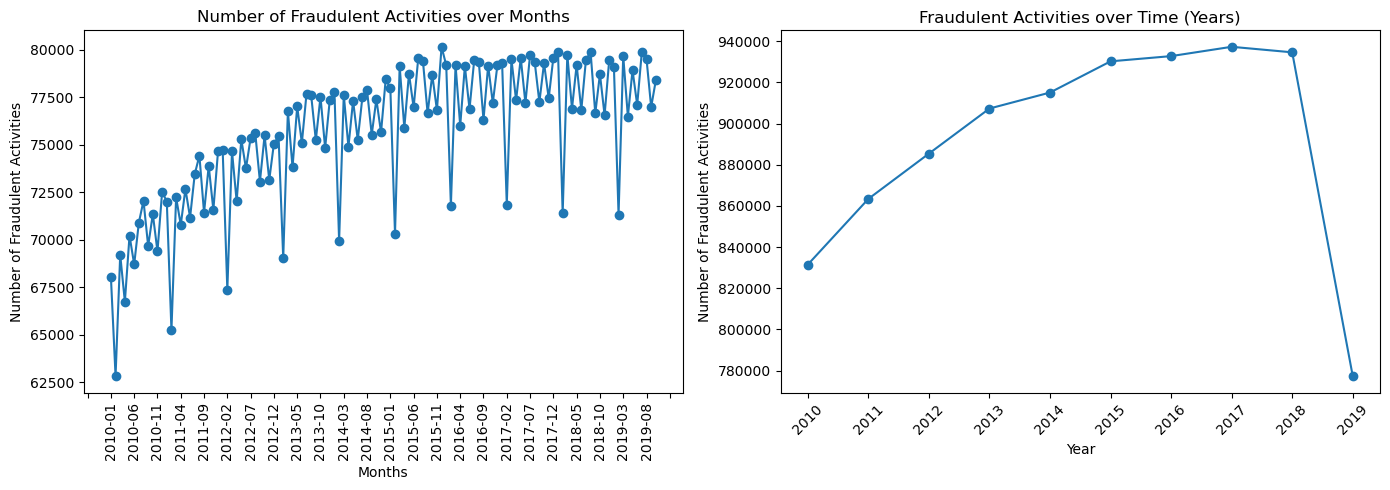

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

# Group number of fraud events per day, month, and year
tfmcu['date'] = tfmcu['date'].dt.date
tfmcu['month'] = pd.to_datetime(tfmcu['date']).dt.to_period('M')
tfmcu['year'] = pd.to_datetime(tfmcu['date']).dt.to_period('Y')

# Group by date, month, and year
tfmcu_day = tfmcu.groupby("date").size().reset_index(name="fraud count")
tfmcu_month = tfmcu.groupby("month").size().reset_index(name="fraud count")
tfmcu_year = tfmcu.groupby("year").size().reset_index(name="fraud count")

# Convert period to string for better plotting
tfmcu_month['month'] = tfmcu_month['month'].astype(str)
tfmcu_year['year'] = tfmcu_year['year'].astype(str)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Fraudulent activities over months
axes[0].plot(tfmcu_month['month'], tfmcu_month['fraud count'], marker='o', linestyle='-')
axes[0].set_title("Number of Fraudulent Activities over Months")
axes[0].set_xlabel("Months")
axes[0].set_ylabel("Number of Fraudulent Activities")
axes[0].tick_params(axis='x', rotation=90)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=30))

# Plot 2: Fraudulent activities over years
axes[1].plot(tfmcu_year['year'], tfmcu_year['fraud count'], marker='o', linestyle='-')
axes[1].set_title("Fraudulent Activities over Time (Years)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Number of Fraudulent Activities")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()


From the date vs frequency plot, fraudulent activity can be seen to be cyclical. Over the years from 2010-2018, there is a steady increase in fradulent activity. The significant drop in 2019 is due to lack of full year's worth of data.

### Categorical Bar Plots

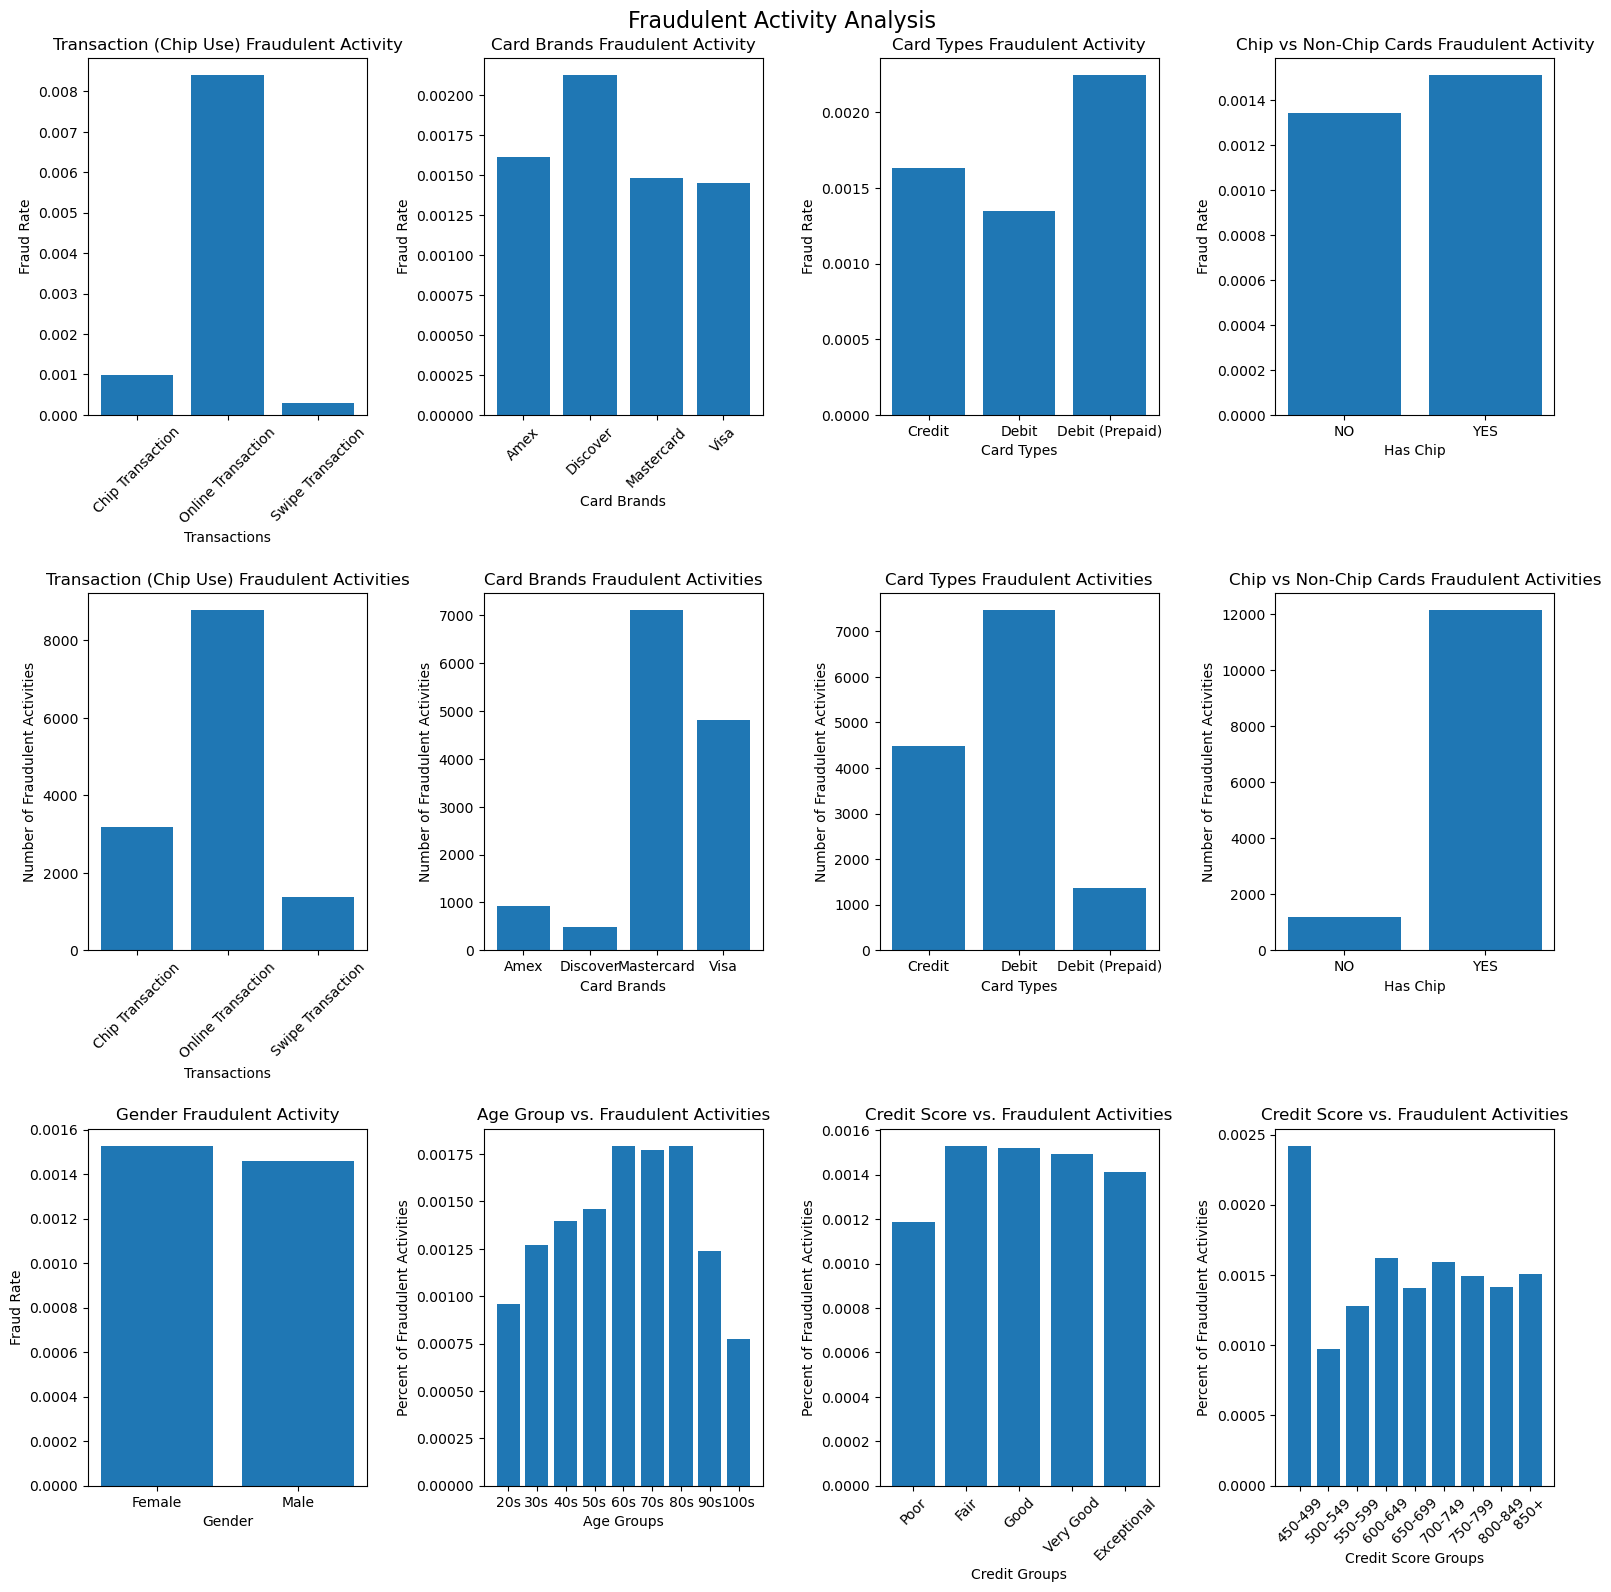

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(16, 16))  # Adjust size as needed

# Transaction (Chip Use) Fraudulent Activity - Fraud Rate
axes[0, 0].bar(tfmcu.groupby("use_chip")["fraud_binary"].mean().index,
               tfmcu.groupby("use_chip")["fraud_binary"].mean())
axes[0, 0].set_xlabel('Transactions')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylabel('Fraud Rate')
axes[0, 0].set_title('Transaction (Chip Use) Fraudulent Activity')

# Card Brand Fraudulent Activity - Fraud Rate
axes[0, 1].bar(tfmcu.groupby("card_brand")["fraud_binary"].mean().index,
               tfmcu.groupby("card_brand")["fraud_binary"].mean())
axes[0, 1].set_xlabel('Card Brands')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylabel('Fraud Rate')
axes[0, 1].set_title('Card Brands Fraudulent Activity')

# Card Type Fraudulent Activity - Fraud Rate
axes[0, 2].bar(tfmcu.groupby("card_type")["fraud_binary"].mean().index,
               tfmcu.groupby("card_type")["fraud_binary"].mean())
axes[0, 2].set_xlabel('Card Types')
axes[0, 2].set_ylabel('Fraud Rate')
axes[0, 2].set_title('Card Types Fraudulent Activity')

# Has Chip Fraudulent Activity - Fraud Rate
axes[0, 3].bar(tfmcu.groupby("has_chip")["fraud_binary"].mean().index,
               tfmcu.groupby("has_chip")["fraud_binary"].mean())
axes[0, 3].set_xlabel('Has Chip')
axes[0, 3].set_ylabel('Fraud Rate')
axes[0, 3].set_title('Chip vs Non-Chip Cards Fraudulent Activity')

# Transaction (Chip Use) Fraudulent Activities - Number of Frauds
axes[1, 0].bar(tfmcu.groupby("use_chip")["fraud_binary"].sum().index,
               tfmcu.groupby("use_chip")["fraud_binary"].sum())
axes[1, 0].set_xlabel('Transactions')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylabel('Number of Fraudulent Activities')
axes[1, 0].set_title('Transaction (Chip Use) Fraudulent Activities')

# Card Brand Fraudulent Activities - Number of Frauds
axes[1, 1].bar(tfmcu.groupby("card_brand")["fraud_binary"].sum().index,
               tfmcu.groupby("card_brand")["fraud_binary"].sum())
axes[1, 1].set_xlabel('Card Brands')
axes[1, 1].set_ylabel('Number of Fraudulent Activities')
axes[1, 1].set_title('Card Brands Fraudulent Activities')

# Card Type Fraudulent Activities - Number of Frauds
axes[1, 2].bar(tfmcu.groupby("card_type")["fraud_binary"].sum().index,
               tfmcu.groupby("card_type")["fraud_binary"].sum())
axes[1, 2].set_xlabel('Card Types')
axes[1, 2].set_ylabel('Number of Fraudulent Activities')
axes[1, 2].set_title('Card Types Fraudulent Activities')

# Has Chip Fraudulent Activities - Number of Frauds
axes[1, 3].bar(tfmcu.groupby("has_chip")["fraud_binary"].sum().index,
               tfmcu.groupby("has_chip")["fraud_binary"].sum())
axes[1, 3].set_xlabel('Has Chip')
axes[1, 3].set_ylabel('Number of Fraudulent Activities')
axes[1, 3].set_title('Chip vs Non-Chip Cards Fraudulent Activities')

# Gender Fraudulent Activity - Fraud Rate
axes[2, 0].bar(tfmcu.groupby("gender")["fraud_binary"].mean().index,
               tfmcu.groupby("gender")["fraud_binary"].mean())
axes[2, 0].set_xlabel('Gender')
axes[2, 0].set_ylabel('Fraud Rate')
axes[2, 0].set_title('Gender Fraudulent Activity')

# Age Group Fraudulent Activity - Fraud Rate
age_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
age_labels = ['10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s']
tfmcu["age_group"] = pd.cut(tfmcu["current_age"], bins=age_bins, labels=age_labels, right=False)
age_grouped = tfmcu.groupby("age_group", observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")
axes[2, 1].bar(age_grouped['age_group'], age_grouped['fraud_rate'])
axes[2, 1].set_xlabel('Age Groups')
axes[2, 1].set_ylabel('Percent of Fraudulent Activities')
axes[2, 1].set_title('Age Group vs. Fraudulent Activities')

# Credit Group Fraudulent Activity - Fraud Rate
credit_bins = [300, 580, 670, 740, 800, 850]
credit_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']
tfmcu["credit_group"] = pd.cut(tfmcu["credit_score"], bins=credit_bins, labels=credit_labels, right=False)
credit_grouped = tfmcu.groupby("credit_group", observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")
axes[2, 2].bar(credit_grouped['credit_group'], credit_grouped['fraud_rate'])
axes[2, 2].set_xlabel('Credit Groups')
axes[2, 2].tick_params(axis='x', rotation=45)
axes[2, 2].set_ylabel('Percent of Fraudulent Activities')
axes[2, 2].set_title('Credit Score vs. Fraudulent Activities')

# Credit Score Group Fraudulent Activity - Fraud Rate
credit_bins = [450, 500, 550, 600, 650, 700, 750, 800, 850, 900]
credit_labels = ['450-499', '500-549', '550-599', '600-649', '650-699', '700-749', '750-799', '800-849', '850+']
tfmcu["credit_score_group"] = pd.cut(tfmcu["credit_score"], bins=credit_bins, labels=credit_labels, right=False)
credit_score_grouped = tfmcu.groupby("credit_score_group", observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")
axes[2, 3].bar(credit_score_grouped["credit_score_group"], credit_score_grouped['fraud_rate'])
axes[2, 3].set_xlabel('Credit Score Groups')
axes[2, 3].tick_params(axis='x', rotation=45)
axes[2, 3].set_ylabel('Percent of Fraudulent Activities')
axes[2, 3].set_title('Credit Score vs. Fraudulent Activities')

# Optional plots
#axes[3, 0].axis('off')
#axes[3, 1].axis('off')
#axes[3, 2].axis('off')
#axes[3, 3].axis('off')

# Adjust layout and display
plt.tight_layout(pad=2.0)  # Adjust padding between subplots for better spacing
plt.suptitle('Fraudulent Activity Analysis', fontsize=16, y = 1)  # Set a main title for the entire figure
plt.show()

Explored fraudulent rates for various categories and can see that certain groups have a higher likelihood of fraud. From the graphs above, online transactions, card type (debit prepaid), and credit score of (450-499) tend to have higher rates compared to other groupings. 

In [28]:
tfmcu.to_csv('output2.csv', index=False)

## Step 3.1: Feature Engineering

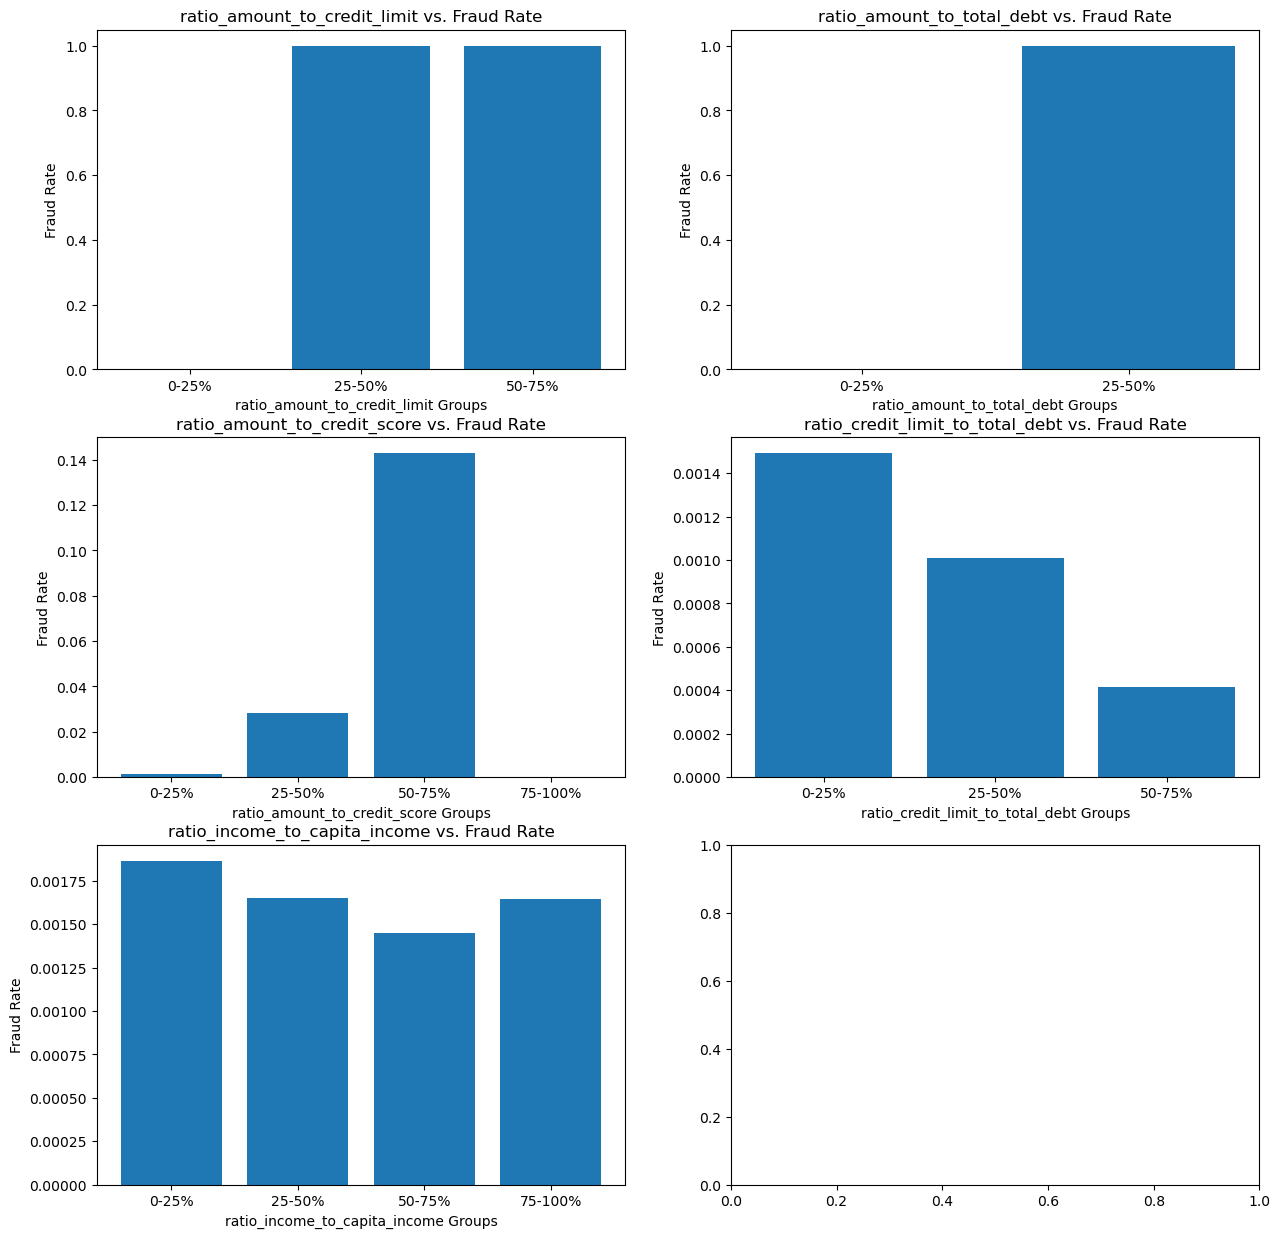

In [30]:
ratio_columns = [
    "ratio_amount_to_credit_limit",
    "ratio_amount_to_total_debt",
    "ratio_amount_to_credit_score",
    "ratio_credit_limit_to_total_debt",
    "ratio_income_to_capita_income"
]

# Function to automate graph creation
def automate_graphs(data, ratio_columns):
    # Setting up the plot grid
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))  # Adjust grid size based on the number of plots
    axes = axes.flatten()  # Flatten for easy iteration

    for i, column in enumerate(ratio_columns):
        if i >= len(axes):  # Avoid errors if too many columns
            break

        # Calculate the min and max
        min_val = data[f'{column}'].min()
        max_val = data[f'{column}'].max()

        # Create 4 sections (quartiles)
        column_bins = [min_val,
                min_val + (max_val - min_val) * 0.25,
                min_val + (max_val - min_val) * 0.5,
                min_val + (max_val - min_val) * 0.75,
                max_val]

        # Generate the data for each column
        #column_bins = [0, 0.25, 0.5, 0.75, 1.0]  # Customize bin ranges if needed
        column_labels = ['0-25%', '25-50%', '50-75%', '75-100%']
        data[f"{column}_group"] = pd.cut(data[column], bins=column_bins, labels=column_labels, right=False)
        grouped_data = data.groupby(f"{column}_group",observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")

        # Create the bar plot
        ax = axes[i]
        ax.bar(grouped_data[f"{column}_group"].astype(str), grouped_data["fraud_rate"])
        ax.set_xlabel(f'{column} Groups')
        ax.set_ylabel('Fraud Rate')
        ax.set_title(f'{column} vs. Fraud Rate')

# Usage
automate_graphs(tfmcu, ratio_columns)


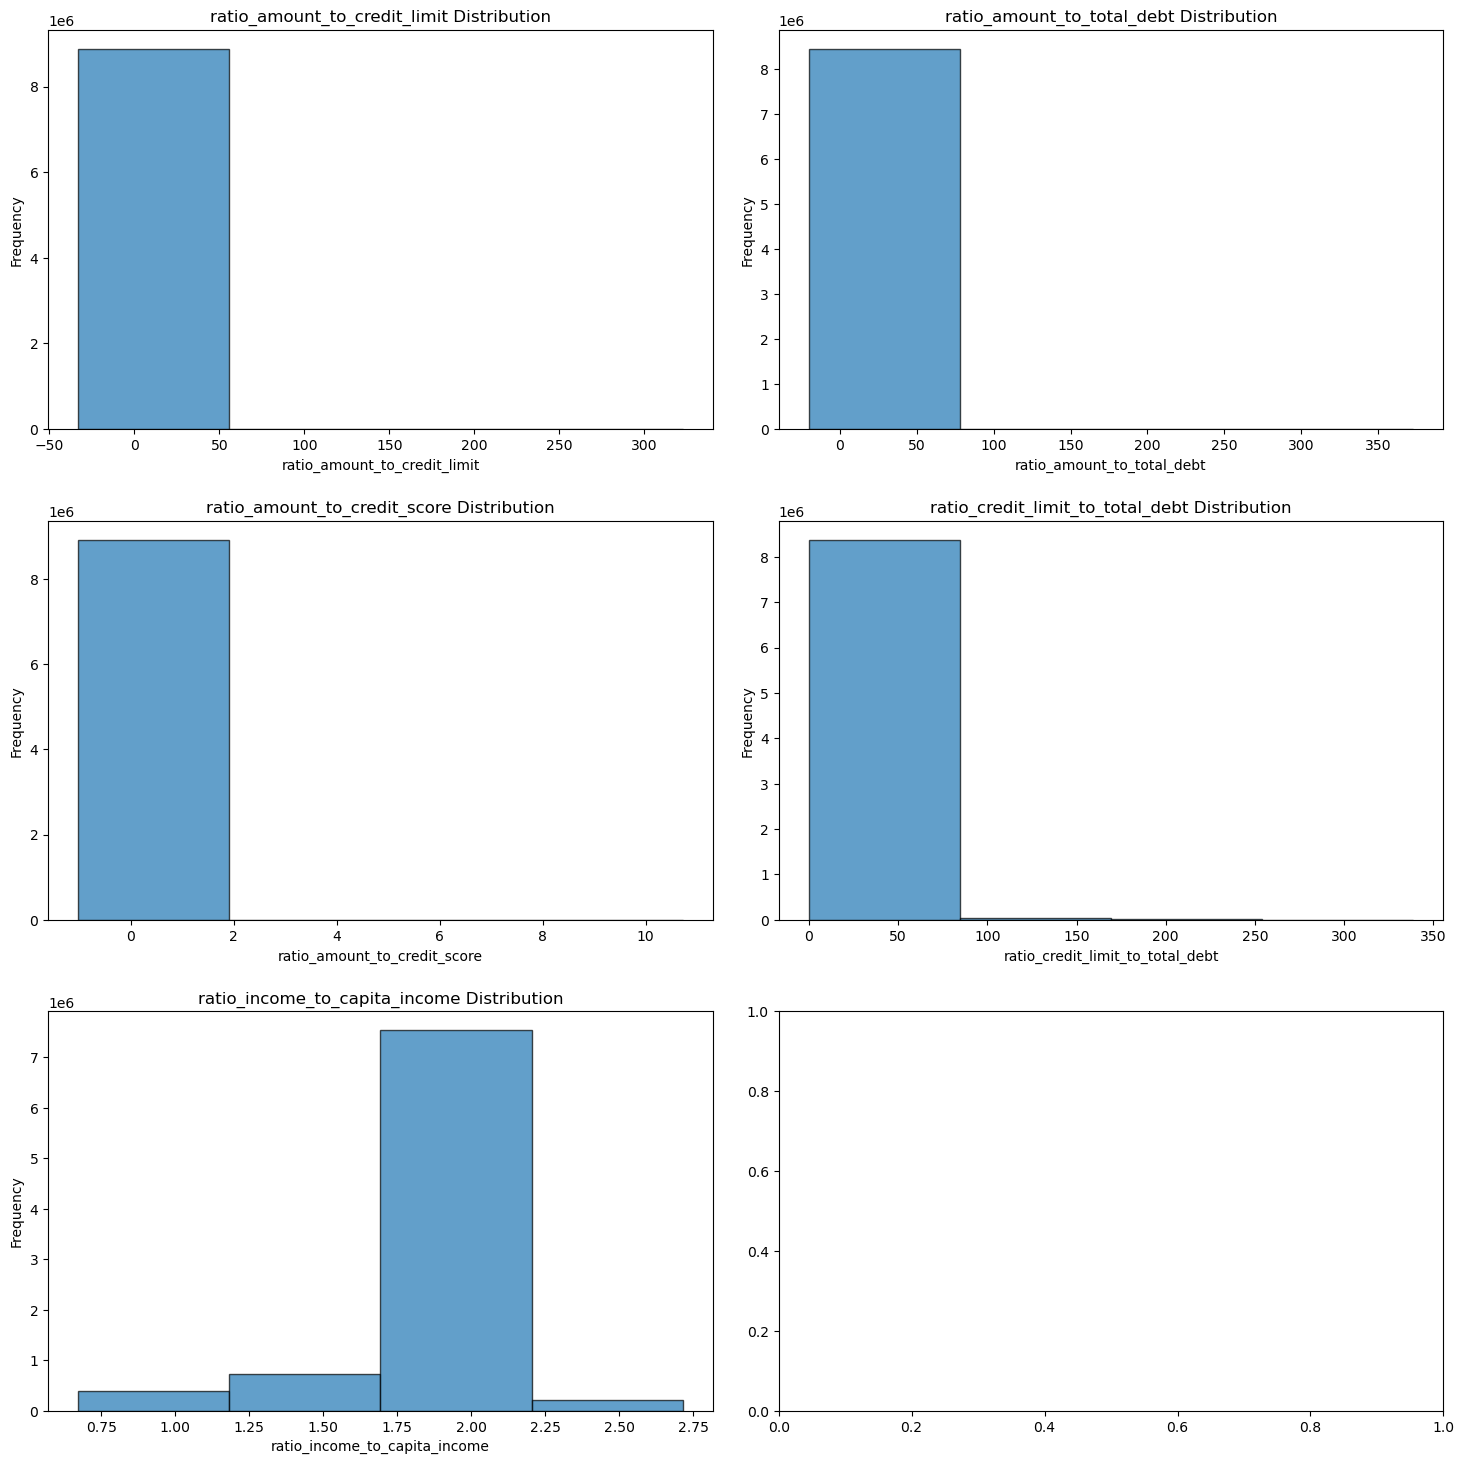

In [31]:
ratio_columns = [
    "ratio_amount_to_credit_limit",
    "ratio_amount_to_total_debt",
    "ratio_amount_to_credit_score",
    "ratio_credit_limit_to_total_debt",
    "ratio_income_to_capita_income"
]

# Function to automate histogram creation
def automate_histograms(data, ratio_columns):
    # Setting up the plot grid
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))  # Adjust grid size based on the number of plots
    axes = axes.flatten()  # Flatten for easy iteration

    for i, column in enumerate(ratio_columns):
        if i >= len(axes):  # Avoid errors if too many columns
            break

        # Create the histogram for each ratio column
        ax = axes[i]
        ax.hist(data[column], bins=4, edgecolor='black', alpha=0.7)

        ax.set_xlabel(f'{column}')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{column} Distribution')

    # Adjust layout for better spacing
    plt.tight_layout(pad=2.0)
    plt.show()

# Usage
automate_histograms(tfmcu, ratio_columns)


<Axes: xlabel='credit_group', ylabel='age_group'>

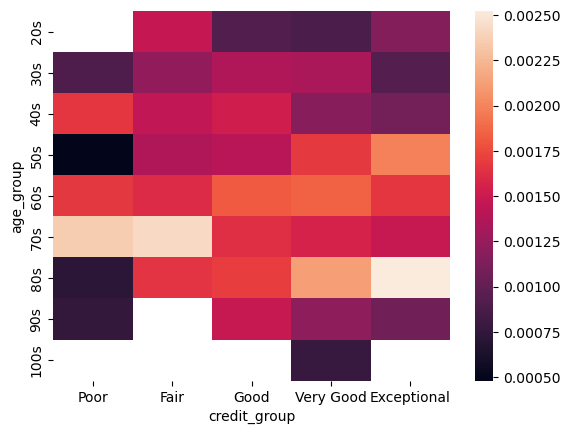

In [32]:
age_v_credit = pd.crosstab(tfmcu["age_group"],tfmcu["credit_group"], values = tfmcu["fraud_binary"],aggfunc = "mean")
sns.heatmap(age_v_credit)

In [33]:
#Correlation for subset of dataframe
corr = tfmcu_sub.corr(method = 'pearson')
corr

,amount,fraud_binary,has_chip_binary,num_cards_issued,credit_limit,year_pin_last_changed,current_age,retirement_age,gender_binary,per_capita_income,...,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,card_brand_Amex,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Credit,card_type_Debit,card_type_Debit (Prepaid)
amount,1.000000,0.031940,0.001276,-0.000289,0.068618,0.006759,-0.004277,-0.005131,-0.000699,0.103255,...,-0.019200,0.063717,-0.022578,0.038281,0.023299,-0.036041,0.010194,0.098277,-0.056714,-0.070768
fraud_binary,0.031940,1.000000,0.001301,-0.000108,-0.005706,0.000152,0.004423,0.000567,-0.000882,-0.002882,...,-0.009763,0.065160,-0.032572,0.000805,0.002630,-0.000365,-0.000885,0.002339,-0.004988,0.005285
has_chip_binary,0.001276,0.001301,1.000000,0.011237,-0.007638,0.016499,-0.010542,-0.000451,-0.014385,-0.020137,...,0.249730,0.013057,-0.248307,0.030331,-0.004340,-0.034428,0.021532,0.003645,-0.002245,-0.002354
num_cards_issued,-0.000289,-0.000108,0.011237,1.000000,-0.067989,0.041302,0.015334,-0.063372,-0.029945,0.010404,...,0.004112,-0.003926,-0.001423,-0.029903,-0.015571,-0.000673,0.020909,-0.031782,0.032125,-0.003516
credit_limit,0.068618,-0.005706,-0.007638,-0.067989,1.000000,-0.038900,-0.035974,0.014058,0.014343,0.608114,...,-0.000806,0.018105,-0.010892,-0.073951,-0.044330,0.029356,0.021286,-0.193059,0.366037,-0.348013
year_pin_last_changed,0.006759,0.000152,0.016499,0.041302,-0.038900,1.000000,-0.030288,0.006921,-0.046884,0.002680,...,0.069936,-0.006036,-0.063298,0.011905,-0.018752,0.020623,-0.021215,0.020447,-0.018329,-0.002217
current_age,-0.004277,0.004423,-0.010542,0.015334,-0.035974,-0.030288,1.000000,-0.008016,-0.040282,0.010588,...,-0.017779,0.005964,0.013240,-0.029858,0.021116,-0.013277,0.021974,-0.011265,0.002395,0.015975
retirement_age,-0.005131,0.000567,-0.000451,-0.063372,0.014058,0.006921,-0.008016,1.000000,0.038112,-0.041218,...,0.004538,0.001770,-0.005498,0.005170,0.010441,-0.049238,0.044762,0.075084,-0.064623,-0.013280
gender_binary,-0.000699,-0.000882,-0.014385,-0.029945,0.014343,-0.046884,-0.040282,0.038112,1.000000,-0.034312,...,-0.007474,-0.009869,0.013534,-0.013182,0.001022,-0.013077,0.019836,-0.000712,0.000636,0.000082
per_capita_income,0.103255,-0.002882,-0.020137,0.010404,0.608114,0.002680,0.010588,-0.041218,-0.034312,1.000000,...,-0.013332,0.027025,-0.004617,-0.002416,-0.009996,-0.013054,0.017906,-0.017664,0.026381,-0.018313


The feature-engineered variables exhibit significant percentage differences within a specific category, which is useful for identifying distinct characteristics of fraudulent behavior.

## Step 4: Modeling (Decision Tree, Logistic Regression, Random Forest)

#### Training and Testing Dataset

In [36]:
def balance_dataset(data, target_column, method='undersample', random_state=42):
    """
    Balance a dataset using undersampling or oversampling.

    Parameters:
        data (pd.DataFrame): The dataset to balance.
        target_column (str): The name of the target column.
        method (str): 'undersample', 'oversample', or 'smote'.
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A balanced dataset.
    """
    X = data.drop(columns=[target_column])  # Features
    y = data[target_column]  # Target

    if method == 'undersample':
        # Using RandomUnderSampler
        rus = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X, y)

    elif method == 'oversample':
        # Using RandomOverSampler
        ros = RandomOverSampler(random_state=random_state)
        X_resampled, y_resampled = ros.fit_resample(X, y)

    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X, y)

    else:
        raise ValueError("Method must be 'undersample', 'oversample', or 'smote'.")

    # Combine resampled features and target into a single DataFrame
    balanced_data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=[target_column])], axis=1)
    return balanced_data


In [37]:
#Create Balance dataset
tfmcu_sub = tfmcu_sub.dropna()
balanced_data = balance_dataset(tfmcu_sub, target_column='fraud_binary', method='undersample')

# Load your dataset - 'fraud_binary' is the target variable and other columns are features
balanced = False
smaller_dataset = False 

if smaller_dataset: 
    tfmcu_sub_small = tfmcu_sub[['amount','fraud_binary', 'has_chip_binary','num_cards_issued', 'credit_limit',
        'year_pin_last_changed', 'current_age','retirement_age', 'gender_binary', 'per_capita_income', 'yearly_income','total_debt', 
        'credit_score', 'num_credit_cards','use_chip_Online Transaction','use_chip_Chip Transaction','use_chip_Swipe Transaction',
        'card_type_Debit (Prepaid)']]
    if balanced:
        balanced_data_small = balance_dataset(tfmcu_sub_small, target_column='fraud_binary', method='undersample')
        X = balanced_data_small.drop(columns=["fraud_binary"])  # Feature columns
        y = balanced_data_small["fraud_binary"]  # Target column (fraud binary)
    else:
        X = tfmcu_sub_small.drop(columns=["fraud_binary"])  # Feature columns
        y = tfmcu_sub_small["fraud_binary"]
        
    # Testing with full dataset
    X_tfmcu = tfmcu_sub_small.drop(columns=["fraud_binary"])  # Feature columns
    y_tfmcu = tfmcu_sub_small["fraud_binary"]  # Target column (fraud binary)

elif balanced:
    X = balanced_data.drop(columns=["fraud_binary"])  # Feature columns
    y = balanced_data["fraud_binary"]  # Target column (fraud binary)
    # Testing with full dataset
    X_tfmcu = tfmcu_sub.drop(columns=["fraud_binary"])  # Feature columns
    y_tfmcu = tfmcu_sub["fraud_binary"]  # Target column (fraud binary)
else:
    X = tfmcu_sub.drop(columns=["fraud_binary"])  # Feature columns
    y = tfmcu_sub["fraud_binary"]
    # Testing with full dataset
    X_tfmcu = tfmcu_sub.drop(columns=["fraud_binary"])  # Feature columns
    y_tfmcu = tfmcu_sub["fraud_binary"]  # Target column (fraud binary)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
tfmcu_sub.columns

Index(['amount', 'fraud_binary', 'has_chip_binary', 'num_cards_issued',
       'credit_limit', 'year_pin_last_changed', 'current_age',
       'retirement_age', 'gender_binary', 'per_capita_income', 'yearly_income',
       'total_debt', 'credit_score', 'num_credit_cards',
       'ratio_amount_to_credit_limit', 'ratio_amount_to_total_debt',
       'ratio_amount_to_credit_score', 'ratio_credit_limit_to_total_debt',
       'ratio_income_to_capita_income', 'use_chip_Chip Transaction',
       'use_chip_Online Transaction', 'use_chip_Swipe Transaction',
       'card_brand_Amex', 'card_brand_Discover', 'card_brand_Mastercard',
       'card_brand_Visa', 'card_type_Credit', 'card_type_Debit',
       'card_type_Debit (Prepaid)'],
      dtype='object')

### Decision Tree - Training and Testing

#### Training

In [41]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Measure of split quality
    'splitter': ['best', 'random'],  # How to choose the split
    'max_depth': [None, 5, 10, 20, 50],  # Limit depth to prevent overfitting
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'min_samples_leaf': [1, 2, 5, 10],  # Minimum samples required in a leaf
    'class_weight': [None, 'balanced'],  # Handle imbalanced datasets
}

param_grid = {'class_weight': [None], 'criterion': ['entropy'], 'max_depth': [50],
              'min_samples_leaf': [2], 'min_samples_split': [5], 'splitter': ['best']}

# Define scoring metrics
scoring = {
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1),
}

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',  # Optimize for F1 score by default
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
)

# Perform the grid search
grid_search_dt.fit(X_train, y_train)

# Retrieve the best parameters
best_params_dt = grid_search_dt.best_params_
print(f"Best Parameters: {best_params_dt}")

best_model_dt = grid_search_dt.best_estimator_
y_train_pred_dt = best_model_dt.predict(X_train)
y_test_pred_dt = best_model_dt.predict(X_test)

# Evaluate the accuracy
accuracy_train_dt = accuracy_score(y_train, y_train_pred_dt)
accuracy_test_dt = accuracy_score(y_test, y_test_pred_dt)
print(f'Accuracy (Train): {accuracy_train_dt}')
print(f'Accuracy (Test): {accuracy_test_dt}')

# Print classification reports
report_train_dt = classification_report(y_train, y_train_pred_dt)
report_test_dt = classification_report(y_test, y_test_pred_dt)
print(f'Training Set Classification Report: \n{report_train_dt}')
print(f'Test Set Classification Report: \n{report_test_dt}')

# Print confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_test_pred_dt)
print(f'Confusion Matrix: \n{conf_matrix_dt}')


Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Accuracy (Train): 0.9991438274632295
Accuracy (Test): 0.9980358919907246
Training Set Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6710622
           1       0.88      0.49      0.63      9986

    accuracy                           1.00   6720608
   macro avg       0.94      0.75      0.82   6720608
weighted avg       1.00      1.00      1.00   6720608

Test Set Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1677692
           1       0.19      0.11      0.14      2460

    accuracy                           1.00   1680152
   macro avg       0.60      0.55      0.57   1680152
weighted avg       1.00      1.00      1.00   1680152

Confusion Matrix: 
[[1676584    1108]
 [   2192     268

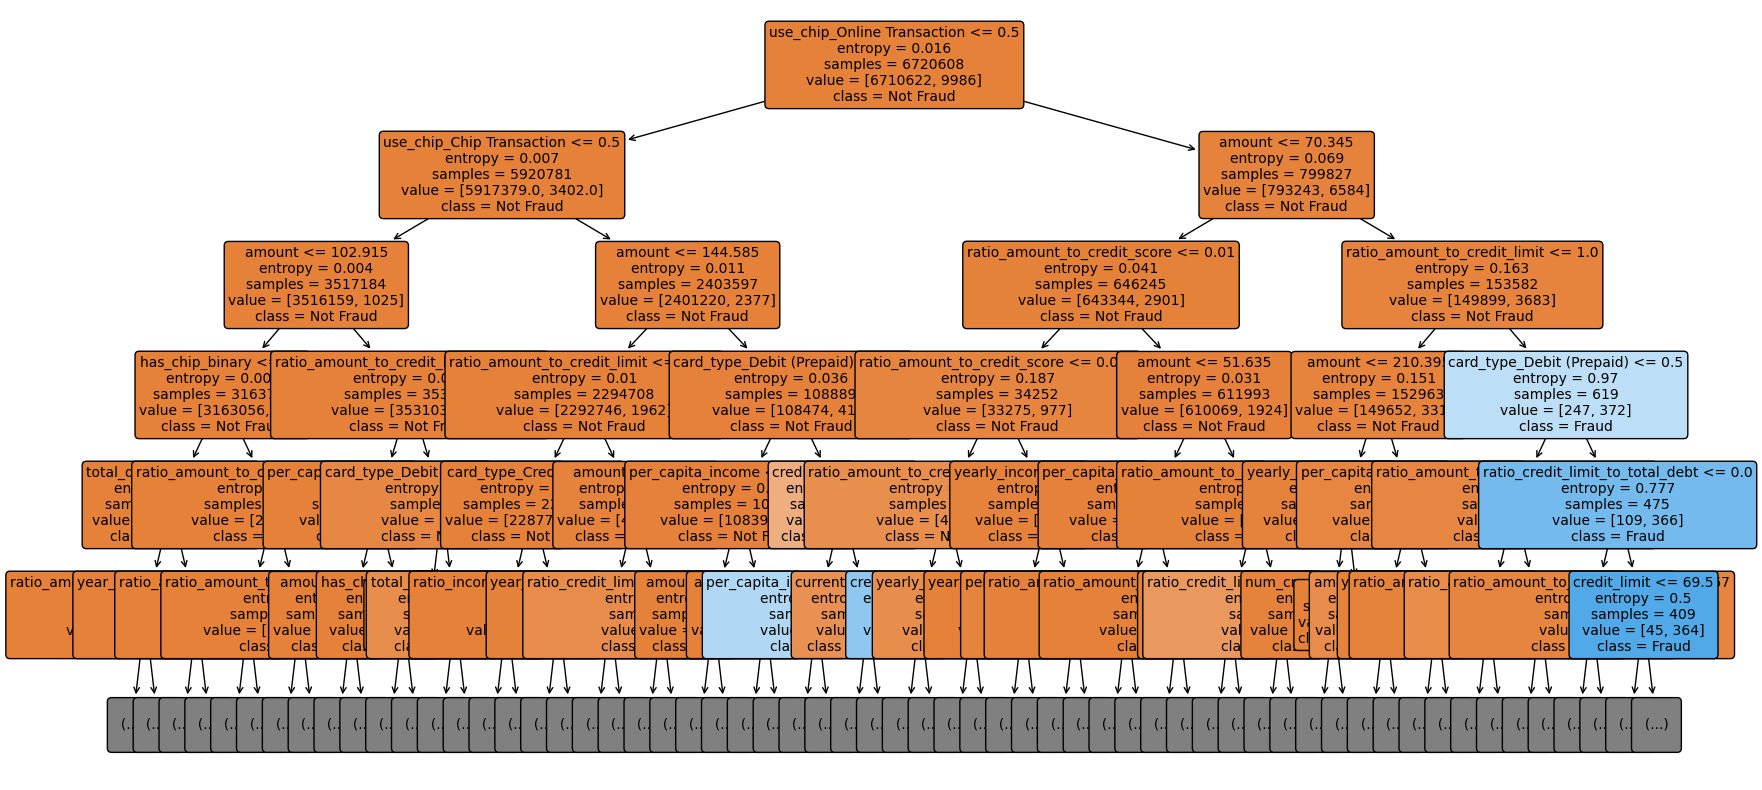

In [42]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))  # Increase the figure size for better visibility
plot_tree(
    best_model_dt,
    feature_names=X_train.columns,  # Replace with your feature names
    class_names=["Not Fraud", "Fraud"],  # Replace with your class names
    filled=True,
    rounded=True,
    fontsize=10,  # Adjust font size for readability
    max_depth=5
)

# Save the figure
plt.savefig("decision_tree.png", dpi=300, bbox_inches='tight')  # Save as a high-quality PNG file

plt.show()

In [43]:
## Exporting feature importances
importances = best_model_dt.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_tfmcu.columns,
    'Importance': importances
    })
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances.to_csv('feature_importances.csv', index=False)
print("Feature importances have been exported to 'feature_importances.csv'.")

Feature importances have been exported to 'feature_importances.csv'.


/var/folders/hf/h9cmj8bx3k1cjblslh6mflfc0000gn/T/ipykernel_35208/2377024381.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


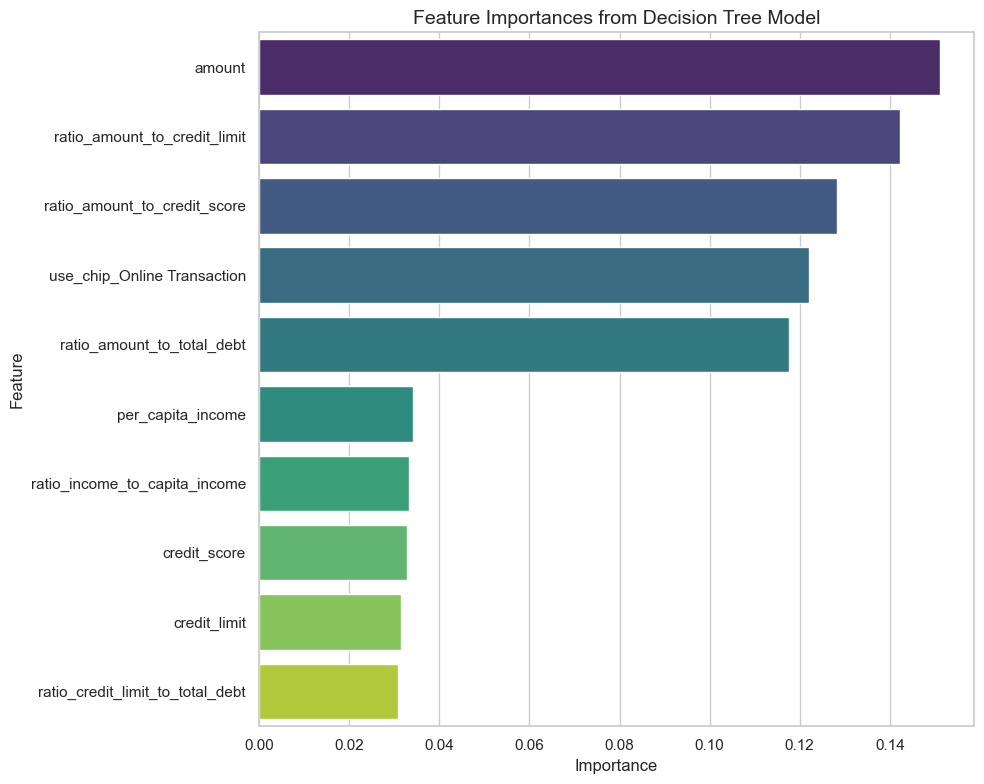

In [44]:
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")

top_features = feature_importances.head(10)
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_features, 
    palette='viridis'
)

plt.title('Feature Importances from Decision Tree Model', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()

# Save the figure
plt.savefig("feature_importances_dt.png", dpi=300, bbox_inches='tight')  # Save as a high-quality PNG file

# Show the plot
plt.show()

### Random Forest

#### Training

In [47]:
param_grid= {
    'n_estimators': [10, 20, 50, 100],  # Number of trees in the forest
    'criterion': ['gini', 'entropy', 'log_loss'],  # Measure of split quality
    'max_depth': [None, 10, 20, 50],  # Limit tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4, 10],  # Minimum samples in leaf nodes
    'max_features': ['sqrt', 'log2', None],  # Number of features considered for split
    'bootstrap': [True, False],  # Bootstrap samples for building trees
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Handle imbalanced datasets
}

param_grid = {'bootstrap': [True], 'class_weight': ['balanced_subsample'], 'criterion': ['entropy'],
              'max_depth': [50], 'max_features': ['sqrt'], 'min_samples_leaf': [6], 'min_samples_split': [15], 
              'n_estimators': [100]}

#Best Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 50, 
#'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 100}

In [48]:
# Initialize and train the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    scoring='f1',  # Adjust as needed
    cv=5,  # Cross-validation folds
 #   n_jobs=-1,  # Use all CPUs
    verbose=1  # Print progress
)
grid_search_rf.fit(X_train, y_train)

# Best model from GridSearchCV
best_model_rf = grid_search_rf.best_estimator_

# Print best parameters and score
best_params_rf = grid_search_rf.best_params_
print("Best Parameters:", best_params_rf)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 100}


In [49]:
# Make predictions using the best model on the test set
y_train_pred_rf = best_model_rf.predict(X_train)
y_test_pred_rf = best_model_rf.predict(X_test)

# Evaluate the accuracy
accuracy_train_rf = accuracy_score(y_train, y_train_pred_rf)
accuracy_test_rf = accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy (Train): {accuracy_train_rf}')
print(f'Accuracy (Test): {accuracy_test_rf}')

# Print classification reports
report_train_rf = classification_report(y_train, y_train_pred_rf)
report_test_rf = classification_report(y_test, y_test_pred_rf)
print(f'Training Set Classification Report: \n{report_train_rf}')
print(f'Test Set Classification Report: \n{report_test_rf}')

# Print confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
print(f'Confusion Matrix: \n{conf_matrix_rf}')

Accuracy (Train): 0.9985227527033268
Accuracy (Test): 0.9968800441864784
Training Set Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6710622
           1       0.50      1.00      0.67      9986

    accuracy                           1.00   6720608
   macro avg       0.75      1.00      0.83   6720608
weighted avg       1.00      1.00      1.00   6720608

Test Set Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1677692
           1       0.12      0.18      0.14      2460

    accuracy                           1.00   1680152
   macro avg       0.56      0.59      0.57   1680152
weighted avg       1.00      1.00      1.00   1680152

Confusion Matrix: 
[[1674473    3219]
 [   2023     437]]


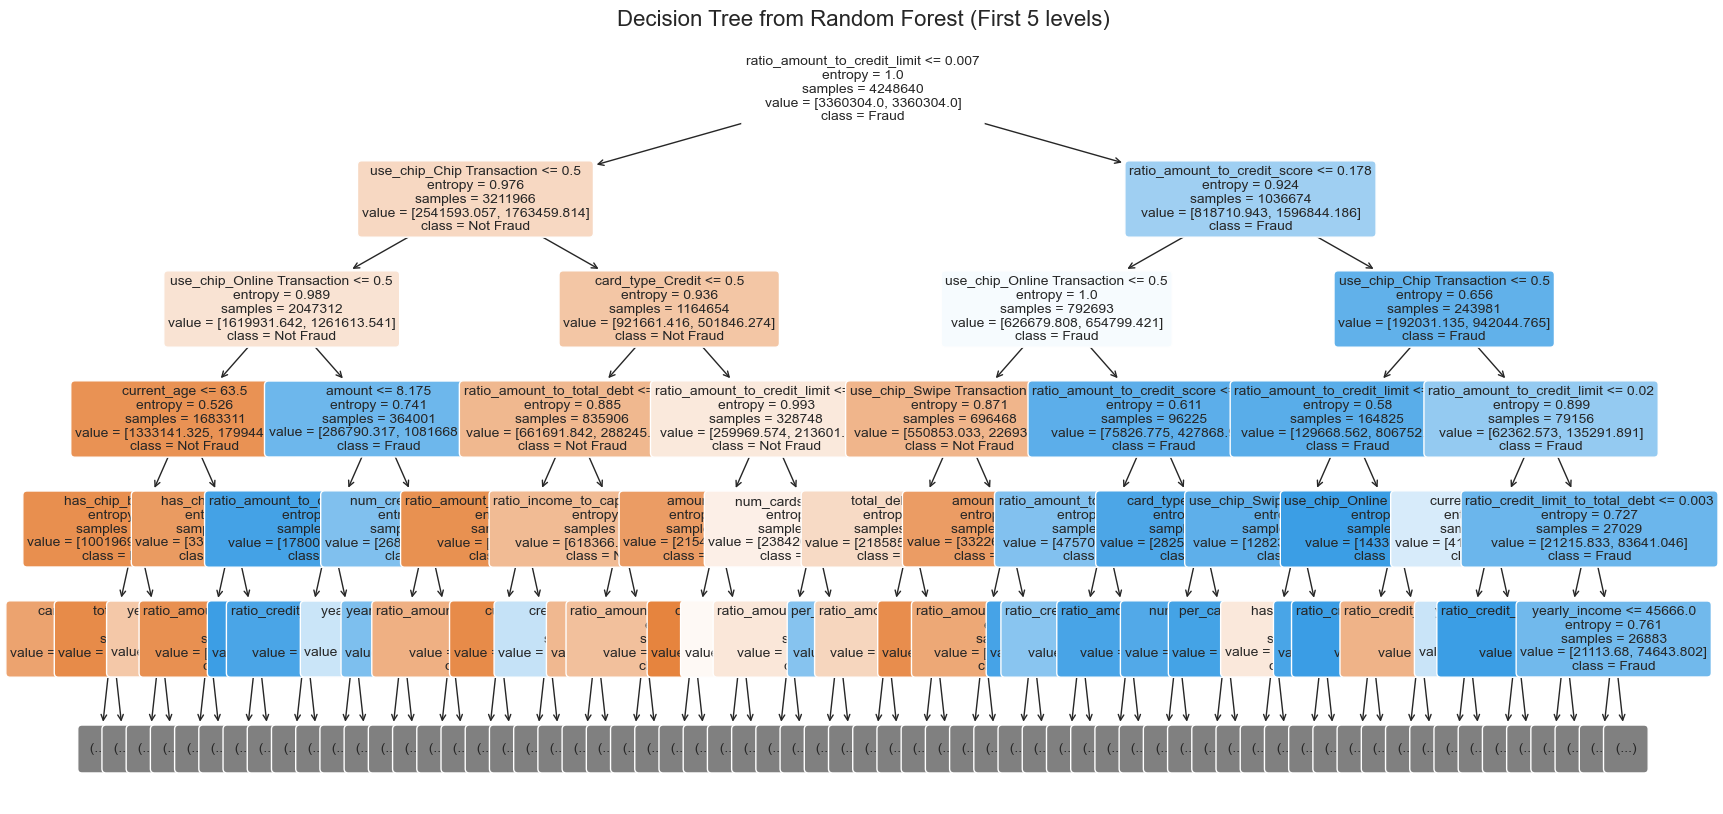

In [50]:
# Extract one tree from the Random Forest
tree = best_model_rf.estimators_[0]

# Option 1: Visualize using plot_tree
plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=X_train.columns,  # Replace with your feature names
    class_names=['Not Fraud', 'Fraud'],  # Replace with class names
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=5
)
plt.title("Decision Tree from Random Forest (First 5 levels)", fontsize=16)
plt.savefig("random_forest_tree.png", dpi=300, bbox_inches='tight')  # Save as a high-quality PNG file
plt.show()



# Option 2: Export to Graphviz for better visualization
export_graphviz(
    tree,
    out_file='tree.dot',
    feature_names=X_train.columns,  # Replace with your feature names
    class_names=['Not Fraud', 'Fraud'],  # Replace with class names
    filled=True,
    rounded=True
)

### Logistic Regression

#### Training

In [53]:
#Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
param_grid = [
    {'penalty': ['l1', 'l2', None], 'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['liblinear', 'saga'], 'max_iter': [100, 500, 1000], 'class_weight': [None, 'balanced']},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['saga'], 'max_iter': [100, 500, 1000], 'class_weight': [None, 'balanced'],
     'l1_ratio': [0.1, 0.5, 0.9]}
]

param_grid = [
    {'penalty': ['l1', 'l2'], 'C': [0.01],
     'solver': ['liblinear', 'saga'], 'max_iter': [100], 'class_weight': ['balanced']},
]

In [54]:
### Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Only transform the test data (to prevent data leakage)
X_test_scaled = scaler.transform(X_test)

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

# Train using the best found parameters
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train_scaled, y_train)

# Make predictions using the best model on the test set
y_train_pred_lr = best_log_reg.predict(X_train_scaled)
y_test_pred_lr = best_log_reg.predict(X_test_scaled)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max

Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [55]:
# Evaluate the accuracy
accuracy_train_lr = accuracy_score(y_train, y_train_pred_lr)
accuracy_test_lr = accuracy_score(y_test, y_test_pred_lr)
print(f'Accuracy (Train): {accuracy_train_lr}')
print(f'Accuracy (Test): {accuracy_test_lr}')

# Print classification reports
report_train_lr = classification_report(y_train, y_train_pred_lr)
report_test_lr = classification_report(y_test, y_test_pred_lr)

print(f'Training Set Classification Report: \n{report_train_lr}')
print(f'Test Set Classification Report: \n{report_test_lr}')

# Print confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_test_pred_lr)
print(f'Confusion Matrix: \n{conf_matrix_lr}')

Accuracy (Train): 0.8544884629485904
Accuracy (Test): 0.854448288012037
Training Set Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.85      0.92   6710622
           1       0.01      0.71      0.01      9986

    accuracy                           0.85   6720608
   macro avg       0.50      0.78      0.47   6720608
weighted avg       1.00      0.85      0.92   6720608

Test Set Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.85      0.92   1677692
           1       0.01      0.70      0.01      2460

    accuracy                           0.85   1680152
   macro avg       0.50      0.78      0.47   1680152
weighted avg       1.00      0.85      0.92   1680152

Confusion Matrix: 
[[1433892  243800]
 [    749    1711]]


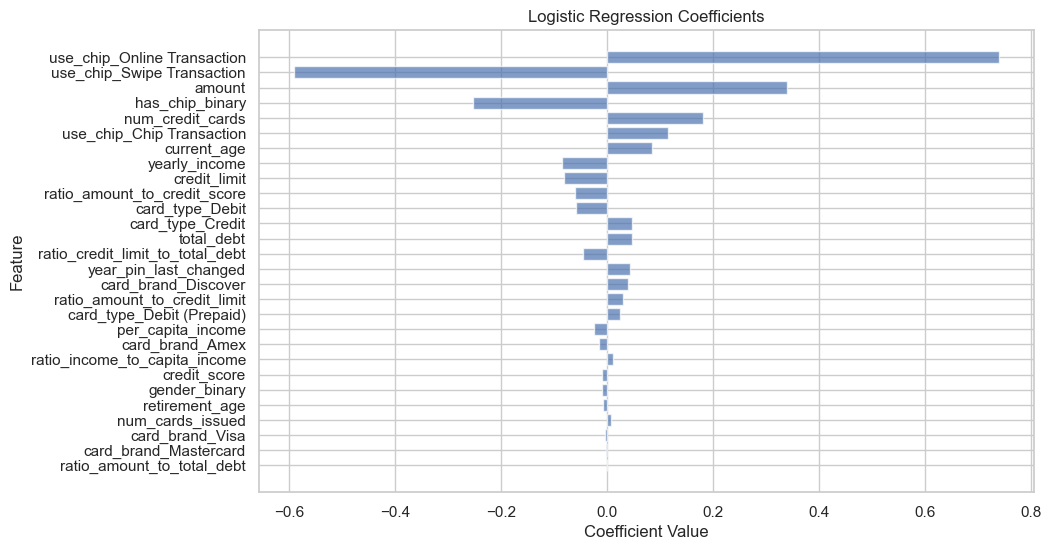

In [99]:
# Get feature names if using a DataFrame, otherwise create numeric labels
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Get coefficients from the trained logistic regression model
coefficients = best_log_reg.coef_[0]  # Extract coefficients for class 1

# Sort coefficients by absolute value for better visualization
sorted_indices = np.argsort(np.abs(coefficients))[::-1]  # Sort in descending order
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_coefficients, color='b', alpha=0.7)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Logistic Regression Coefficients")
plt.gca().invert_yaxis()  # Invert to have the highest impact feature on top
plt.savefig("Logistic_Regression_Coefficients.png", dpi=300, bbox_inches='tight')  # Save as a high-quality PNG file
plt.show()

## Step 5: Analysis Insights

### Adding all the predicted fraud into the main dataset

In [58]:
# Function to extract fraud detection metrics specifically for class 1 (fraud)
def extract_fraud_metrics(y_true, y_pred, X_data, model_name, dataset_type):
    fraud_indices = (y_true == 1) & (y_pred == 1)  # Where actual and predicted are both fraud
    fraud_amounts = X_data.loc[fraud_indices, 'amount']  # Extract fraudulent transaction amounts
    
    # Extract precision, recall, and F1-score for class 1
    class_1_metrics = classification_report(y_true, y_pred, output_dict=True).get('1', {})
    
    return {
        'Model': model_name,
        'Dataset': dataset_type,  # Training or Testing
        'Precision': class_1_metrics.get('precision', 0),
        'Recall': class_1_metrics.get('recall', 0),
        'F1 Score': class_1_metrics.get('f1-score', 0),
        'Mean Fraud Amount': fraud_amounts.mean(),  
        'Total Fraud Amount': fraud_amounts.sum(),  
        'Fraud Count': len(fraud_amounts)  
    }

# Store results for each model separately for training and testing
models_results = []

# Append testing results
models_results.append(extract_fraud_metrics(y_test, y_test_pred_dt, X_test, "Decision Tree", "Testing"))
models_results.append(extract_fraud_metrics(y_test, y_test_pred_rf, X_test, "Random Forest", "Testing"))
models_results.append(extract_fraud_metrics(y_test, y_test_pred_lr, X_test, "Logistic Regression", "Testing"))

# Append training results
models_results.append(extract_fraud_metrics(y_train, y_train_pred_dt, X_train, "Decision Tree", "Training"))
models_results.append(extract_fraud_metrics(y_train, y_train_pred_rf, X_train, "Random Forest", "Training"))
models_results.append(extract_fraud_metrics(y_train, y_train_pred_lr, X_train, "Logistic Regression", "Training"))

# Convert to DataFrame
df_results = pd.DataFrame(models_results)
df_results.to_csv("model_results.csv", index=False)

# Separate DataFrames for training and testing
df_train = df_results[df_results['Dataset'] == "Training"]
df_test = df_results[df_results['Dataset'] == "Testing"]

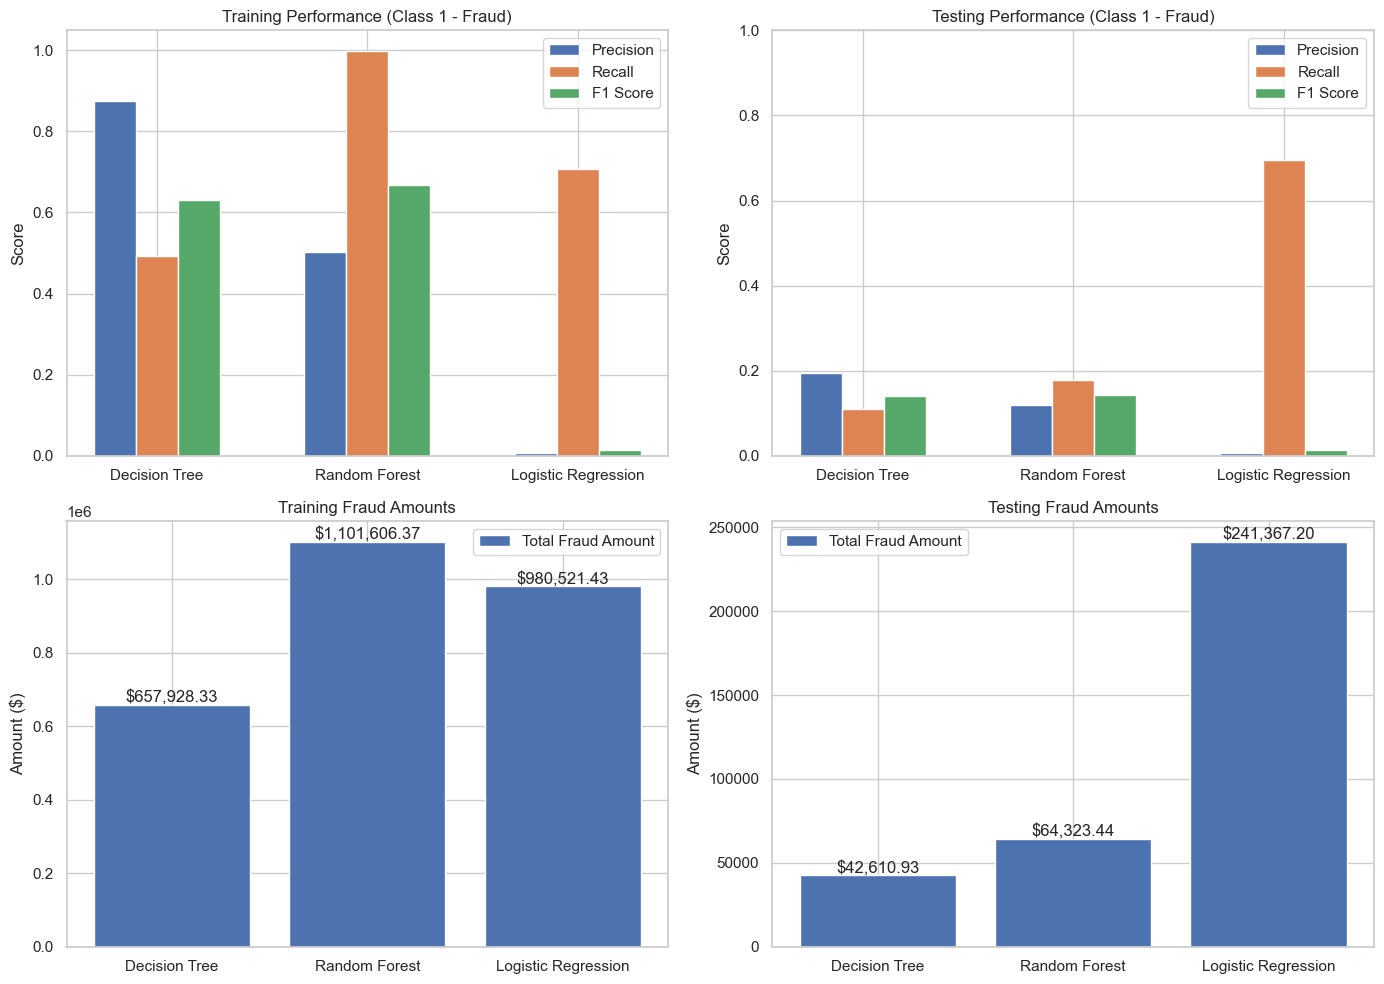

In [95]:
# Plot settings
bar_width = 0.2
x_train = np.arange(len(df_train))
x_test = np.arange(len(df_test))
metrics = ['Precision', 'Recall', 'F1 Score']

# Create subplots: 2 rows (Performance, Fraud Amounts)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Training Performance Plot ---
ax1 = axes[0, 0]
for i, metric in enumerate(metrics):
    ax1.bar(x_train + i * bar_width, df_train[metric], width=bar_width, label=metric)

ax1.set_xticks(x_train + bar_width)
ax1.set_xticklabels(df_train['Model'])
ax1.set_ylabel('Score')
ax1.set_title('Training Performance (Class 1 - Fraud)')
ax1.legend()

# --- Testing Performance Plot ---
ax2 = axes[0, 1]
for i, metric in enumerate(metrics):
    ax2.bar(x_test + i * bar_width, df_test[metric], width=bar_width, label=metric)

ax2.set_xticks(x_test + bar_width)
ax2.set_xticklabels(df_test['Model'])
ax2.set_ylabel('Score')
ax2.set_ylim(0,1)
ax2.set_title('Testing Performance (Class 1 - Fraud)')
ax2.legend()

# --- Training Fraud Amounts ---
ax3 = axes[1, 0]
bars_train = ax3.bar(x_train, df_train['Total Fraud Amount'], label='Total Fraud Amount')

# Annotating each bar in the Training plot
for bar in bars_train:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, yval, f"${yval:,.2f}", ha='center', va='bottom', fontsize=12)

ax3.set_xticks(x_train)
ax3.set_xticklabels(df_train['Model'])
ax3.set_ylabel('Amount ($)')
ax3.set_title('Training Fraud Amounts')
ax3.legend()

# --- Testing Fraud Amounts ---
ax4 = axes[1, 1]
bars_test = ax4.bar(x_test, df_test['Total Fraud Amount'], label='Total Fraud Amount')

# Annotating each bar in the Training plot
for bar in bars_test:
    yval = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, yval, f"${yval:,.2f}", ha='center', va='bottom', fontsize=12)

ax4.set_xticks(x_test)
ax4.set_xticklabels(df_test['Model'])
ax4.set_ylabel('Amount ($)')
ax4.set_title('Testing Fraud Amounts')
ax4.legend()

plt.tight_layout()
# Save the figure
plt.savefig("Train_Test_Perf_Results.png", dpi=300, bbox_inches='tight')  # Save as a high-quality PNG file

plt.show()

Outcome:

- The Decision Tree model demonstrated the highest precision in both training and testing, making it the most accurate at identifying fraud when it predicted a transaction as fraudulent.
- The Random Forest model performed best in predicting total fraud dollar amounts during training, indicating strong overall fraud detection capability.
- While Logistic Regression detected the highest total fraud dollar amount, it also had a significantly high recall but very low precision, making it unreliable due to excessive false positives as well as creating operational constraints and poor customer experience.
